In [1]:
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
from pyearth import Earth

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

In [2]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')    ; cowpea['crop']   = 'cowpea'
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')      ; maize['crop']    = 'maize'
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')        ; rice['crop']     = 'rice'
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea'); chickpea['crop'] = 'chickpea'
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')  ; mustard['crop']  = 'mustard'

In [3]:
# data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)
data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)

In [4]:
clf = LocalOutlierFactor(n_neighbors=20)

new_data = []
org_cols = data.columns
for i, outlier_label in enumerate(clf.fit_predict(data[['GSR', 'CT']])):
    if outlier_label==1:
        new_data.append(data.iloc[i,:])
data = pd.DataFrame(new_data, columns=org_cols)

In [5]:
data = data[(data['GSR']<300) | (data['Rn']>150)]
data = data[(data['Rn']<500) | (data['crop']!='cowpea')]
data = data[(data['Rn']<400) | (data['GSR']>500) | (data['crop']!='rice')]
data = data[(data['Rn']<300) | (data['GSR']>375)]

In [6]:
data.loc[:, 'Time'] = data.loc[:, 'Time'].apply(lambda x: x.hour)
data.loc[:, 'timesin'] = np.sin(data.loc[:, 'Time'] * (2 * np.pi) / 12)
data.loc[:, 'timecos'] = np.cos(data.loc[:, 'Time'] * (2 * np.pi) / 12)

In [7]:
df = pd.get_dummies(data[['crop']])
data = pd.concat([df, data], axis=1)

In [8]:
scalerx = RobustScaler()
scalery = RobustScaler()
data[['GSR','CT',]] = scalerx.fit_transform(data[['GSR','CT']])
data[['Rn']] = scalery.fit_transform(data[['Rn']])

In [9]:
feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
X = data[feature_cols]
y = data['Rn']

In [10]:
#Fit an Earth model
model = Earth(max_degree=5, minspan_alpha=0.01, smooth=True, thresh=0., feature_importance_type='gcv')
model.fit(X,y)

Earth(feature_importance_type='gcv', max_degree=5, minspan_alpha=0.01,
      smooth=True, thresh=0.0)

In [11]:
#Print the model
print(model.trace())
print(model.summary())

Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.470869  1      0.474  0.000  0.000  
1     0       5    -1    0.109633  2      0.112  0.767  0.763  
2     1       2    -1    0.094729  3      0.099  0.799  0.792  
3     0       3    -1    0.081204  4      0.086  0.828  0.818  
4     0       4    -1    0.077113  5      0.083  0.836  0.824  
5     1       7    -1    0.073791  6      0.081  0.843  0.829  
6     5       5    219   0.071324  8      0.082  0.849  0.828  
7     0       6    31    0.067779  10     0.081  0.856  0.830  
8     6       6    226   0.067035  12     0.083  0.858  0.825  
9     0       6    31    0.067035  14     0.086  0.858  0.818  
10    0       6    31    0.067035  16     0.090  0.858  0.811  
11    9       2    -1    0.063506  17     0.087  0.865  0.817  
12    1       6    20    0.

In [ ]:
model.feature_importances_

In [12]:
kfold = KFold(n_splits=10)

In [13]:
all_stacked_mses = []
all_stacked_rmses = []
for (t_, v_) in kfold.split(X, y):
    model.fit(X.iloc[t_], y.iloc[t_])
    y_pred = scalery.inverse_transform(model.predict(X.iloc[v_][feature_cols]).reshape(-1,1))
    y_true = scalery.inverse_transform(y.iloc[v_].values.reshape(-1,1))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    all_stacked_mses.append(mse)
    all_stacked_rmses.append(rmse)
#     print("Regression spline MSE:", mse)
#     print("Regression spline RMSE:", rmse)
#     print("\n")

print("Regression spline mean MSE:", np.mean(all_stacked_mses))
print("Regression spline mean RMSE:", np.mean(all_stacked_rmses))

Regression spline mean MSE: 4308.779736079421
Regression spline mean RMSE: 64.62831057793338


In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

reg_tree1 = RandomForestRegressor()
reg_tree2 = AdaBoostRegressor()

In [16]:
all_stacked_mses = []
all_stacked_rmses = []
for (t_, v_) in kfold.split(X, y):
    reg_tree1.fit(X.iloc[t_], y.iloc[t_])
    y_pred = scalery.inverse_transform(reg_tree1.predict(X.iloc[v_][feature_cols]).reshape(-1,1))
    y_true = scalery.inverse_transform(y.iloc[v_].values.reshape(-1,1))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    all_stacked_mses.append(mse)
    all_stacked_rmses.append(rmse)
#     print("RF MSE:", mse)
#     print("RF RMSE:", rmse)
#     print("\n")

print("RF mean MSE:", np.mean(all_stacked_mses))
print("RF mean RMSE:", np.mean(all_stacked_rmses))

RF mean MSE: 3478.708792842346
RF mean RMSE: 57.80298689614254


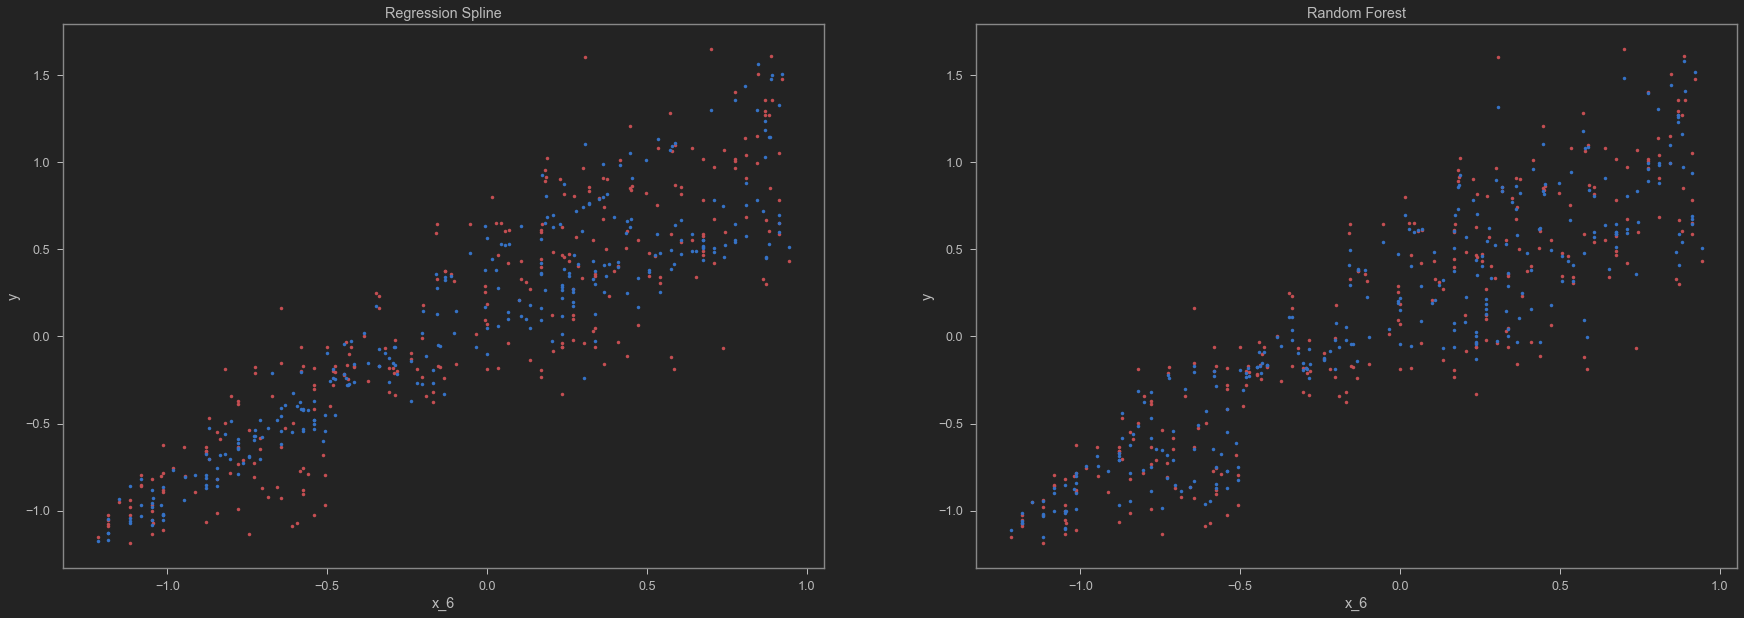

In [18]:
#Plot the model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))

y_hat = model.predict(X)
axes[0].plot(X.iloc[:,5],y,'r.')
axes[0].plot(X.iloc[:,5],y_hat,'b.')
axes[0].set_xlabel('x_6')
axes[0].set_ylabel('y')
axes[0].set_title('Regression Spline')

y_hat_tree = reg_tree1.predict(X)
axes[1].plot(X.iloc[:,5],y,'r.')
axes[1].plot(X.iloc[:,5],y_hat_tree,'b.')
axes[1].set_xlabel('x_6')
axes[1].set_ylabel('y')
axes[1].set_title('Random Forest')

plt.show()

In [24]:
all_stacked_mses = []
all_stacked_rmses = []
for (t_, v_) in kfold.split(X, y):
    model.fit(X.iloc[t_], y.iloc[t_])
    reg_tree1.fit(X.iloc[t_], y.iloc[t_])
    reg_tree2.fit(X.iloc[t_], y.iloc[t_])
    y_pred1 = scalery.inverse_transform(reg_tree1.predict(X.iloc[v_][feature_cols]).reshape(-1,1))
    y_pred2 = scalery.inverse_transform(model.predict(X.iloc[v_][feature_cols]).reshape(-1,1))
    y_pred3 = scalery.inverse_transform(reg_tree2.predict(X.iloc[v_][feature_cols]).reshape(-1,1))
    y_pred  = (y_pred1+y_pred2*0.5+y_pred3*0.5)/2
    y_true = scalery.inverse_transform(y.iloc[v_].values.reshape(-1,1))
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    all_stacked_mses.append(mse)
    all_stacked_rmses.append(rmse)
    print("Stacked estimator MSE:", mse)
    print("Stacked estimator RMSE:", rmse)
    print("\n")

print("Stacked estimator mean MSE:", np.mean(all_stacked_mses))
print("Stacked estimator mean RMSE:", np.mean(all_stacked_rmses))

Stacked estimator MSE: 3709.695097198544
Stacked estimator RMSE: 60.90726637437067


Stacked estimator MSE: 2252.430874101541
Stacked estimator RMSE: 47.45978164827079


Stacked estimator MSE: 5430.3656072172735
Stacked estimator RMSE: 73.69101442657221


Stacked estimator MSE: 4482.865234060058
Stacked estimator RMSE: 66.95420251231478


Stacked estimator MSE: 3772.1667915274747
Stacked estimator RMSE: 61.41796798598497


Stacked estimator MSE: 5385.844908175289
Stacked estimator RMSE: 73.38831588322006


Stacked estimator MSE: 1589.882992007141
Stacked estimator RMSE: 39.873336855687675


Stacked estimator MSE: 3704.8907623724617
Stacked estimator RMSE: 60.86781384584518


Stacked estimator MSE: 1666.3950233159399
Stacked estimator RMSE: 40.82150197280766


Stacked estimator MSE: 2378.638994462232
Stacked estimator RMSE: 48.77129272904535


Stacked estimator mean MSE: 3437.3176284437955
Stacked estimator mean RMSE: 57.41524942341194


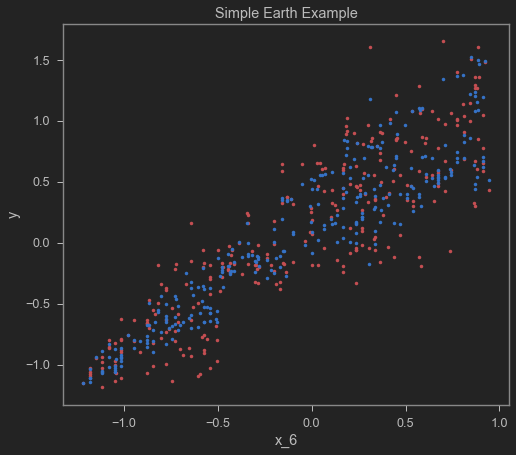

In [25]:
#Plot the model
y_pred_combined = (reg_tree1.predict(X) + model.predict(X)*2.)/3.
plt.figure()
plt.plot(X.iloc[:,5],y,'r.')
plt.plot(X.iloc[:,5],y_pred_combined,'b.')
plt.xlabel('x_6')
plt.ylabel('y')
plt.title('Simple Earth Example')
plt.show()